In [1]:
import os
import subprocess
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
from time import time as t
from numba import jit

# import io

# import datetime

import astropy
import astropy.units as u
import astropy.constants as c

# from IPython.display import Image, display_png


In [565]:
%matplotlib inline
# %matplotlib notebook

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["font.size"] = 15
plt.rcParams["figure.dpi"] = 150

lss = ['-', '--', '-.', ':']

In [3]:
# filepath_ = "../../hewd/gamtmp.d"
filepath_ = "../../cowd/gamtmp.d"

directory_ML = "/Users/kawana/GoogleDrive/sync/study/yoshidalab/mypaper/0002_WD_TDE_radiation_transfer/WhiteDwarf_Thermonuclear_Transients/"
filepaths_spectra_ML = subprocess.getoutput('find "{}/WD06_spectra/" | grep ".par" | sort'.format(directory_ML)).split("\n")[1:]

vel = np.array([2.56466437e+03, 1.18143578e+04, -1.41779372e+00]) * 1e5

# f_ = open(filepath_, mode="r") 

In [483]:
bands_from_blue = np.array(["UVW2", "UVM2", "UVW1", "U", "B", "V", "R", "I", "J", "H", "K"])
color_from_blue = np.array([plt.cm.jet(i/bands_from_blue.size) for i in range(bands_from_blue.size)])
dict_color = dict(zip(bands_from_blue, color_from_blue))

In [579]:
# @jit
def _spectra_Doppler_shift_by_intrinsic_velocity(spectra, 
                                                 velocity, 
                                                 way_interpolate_theta_phi = "equal solid angle",
                                                 way_interpolate_wavelength = "linear",
                                                 inplace = False):
    """
    aliased by Spectra.shift_by_intrinsic_velocity
    optimized with numba.jit
    """

    ways_avail_wavelength = ["linear"]
    ways_avail_theta_phi  = ["linear", "equal solid angle"]

    if not(np.sum([way_interpolate_wavelength == way_avail for way_avail in ways_avail_wavelength])):
        raise ValueError("way_interpolate_wavelength {} is not supported now")
    if not(np.sum([way_interpolate_theta_phi == way_avail for way_avail in ways_avail_theta_phi])):
        raise ValueError("way_interpolate_theta_phi {} is not supported now")

    new_spectra = copy.deepcopy(spectra)

    if (way_interpolate_theta_phi == "linear"):
        mean_thetas = np.append([0], spectra.thetas)
        mean_thetas = 0.5 * (mean_thetas[1:] + mean_thetas[:-1])
    elif (way_interpolate_theta_phi == "equal solid angle"):
        mean_thetas = np.cos(np.append([0.], spectra.thetas))
        mean_thetas = np.arccos(0.5 * (mean_thetas[1:] + mean_thetas[:-1]))

    mean_phis   = np.append([0], spectra.phis)
    mean_phis   = 0.5 * (mean_phis[1:] + mean_phis[:-1])
    
    
    N_time  = spectra.times.size
    N_theta = mean_thetas.size
    N_phi   = mean_phis.size
    
    
    vec_normal = np.ones((N_theta, N_phi, 3), dtype=np.float)
    vec_normal *= np.array([np.cos(mean_phis), np.sin(mean_phis), [1.] * N_phi]).swapaxes(0,1)
    vec_normal = vec_normal.swapaxes(0,1) * np.array([np.sin(mean_thetas), np.sin(mean_thetas), np.cos(mean_thetas)]).swapaxes(0,1)
    vec_normal = vec_normal.swapaxes(0,1)
    Doppler_shift_arr = 1. - np.dot(vec_normal, velocity) / c.c.cgs.value
    Doppler_shift_inv_square = Doppler_shift_arr**-2
    
    for i in range(N_time):
        for j in range(N_theta):
            for k in range(N_phi):
                new_spectra.data[i,j,k] = np.interp(spectra.wavelengths / Doppler_shift_arr[j,k], spectra.wavelengths, spectra.data[i,j,k] * Doppler_shift_inv_square[j,k] )
    
    new_spectra.Doppler_shift_intrinsic = Doppler_shift_arr
    
    if (inplace):
        spectra = copy.copy(new_spectra)
        spectra.data = new_spectra.data
        spectra.data = 1.
        return
    else:
        return new_spectra

#     for i in range(N_theta):
#         for j in range(N_phi):
#             vec_normal = np.array(np.sin(the))
#             redshift = 1 - np.dot(veocity)
    


In [588]:
class Spectra(object):
    """
    Type containing spectra
    
    members
    =======
    times      :
    thetas     :
    phis       :
    wavelengths:
    data       : units of erg/ s/ AA (isotropic flux)
   
    methods
    =======
    binning
    calc_bolometric_luminosity
    calc_band_light_curve
    Doppler_shift_by_intrinsic_velocity
    # redshift
    # dust_extinction
    
    """

    def __init__(self):
        self.times = None
        self.thetas = None
        self.phis = None
        self.wavelengths = None
        self.data = None # in units of erg/ s/ AA (isotropic flux)
        self.Doppler_shift_intrinsic = None # 1 + z
    
    def binning(self,
                every_time: int = 1,
                N_theta_bins: int = 1,
                N_phi_bins : int = 1,
                every_wavelength: int = 1,
                inplace=False):
        """
        binning spectra with given every_wavelength, N_theta_bins, and N_phi_bins


        arguments
        =========
        every_time      :
        N_theta_bins    :
        N_phi_bins      :
        every_wavelength:
        inplace         :

        requirement
        ===========
        mod(N_size, N_bins) = 0 or mod(N_size, every) = 0
        * KK will implement generalized binning using interpolation 

        return
        ======
        spectra   : float, np.ndarray: 
        
        
        description
        ===========
        The ways of binning along each axis are
        time      : 
        wavelength: calculated from mean_i(ln(freq[i]))
        theta, phi: the max of the boundary of bin 
        """
        if (self.thetas.size % N_theta_bins != 0):
            raise ValueError ("mod(N_theta_input, N_theta_bins) must be 0")
        if (self.phis.size % N_phi_bins != 0):
            raise ValueError ("mod(N_phi_input, N_phi_bins) must be 0")
        if (self.times.size % every_time != 0):
            raise ValueError ("mod(N_time_input, every_time) must be 0")
        if (self.wavelengths.size % every_wavelength != 0):
            raise ValueError ("mod(N_wavelength_input, every_wavelength) must be 0")

        new_spectra = Spectra()

        
        # simple mean for theta & phi
        N_time_bins       = int(self.times.size / every_time)
        theta_every       = int(self.thetas.size / N_theta_bins)
        phi_every         = int(self.phis.size / N_phi_bins)
        N_wavelength_bins = int(self.wavelengths.size / every_wavelength)
        
        new_spectra.thetas      = self.thetas[theta_every-1::theta_every]
        new_spectra.phis        = self.phis[phi_every-1::phi_every]

        data = self.data.reshape(self.times.size,
                                 N_theta_bins, 
                                 theta_every, 
                                 N_phi_bins, 
                                 phi_every,
                                 self.wavelengths.size
                                )
        
        data = data.mean(axis=(2, 4))

        
        # time binning
        if (every_time <= 1):
            new_spectra.times = self.times
        else:
            # assme exponential bin
            new_spectra.times       = np.exp(np.log(self.times.reshape(N_time_bins, every_time)).mean(axis=1))
            last_time        = np.exp(np.log(self.times[-1]) + np.diff(np.log(self.times))[-1])
            time_delta       = np.diff(np.append(self.times, last_time))
            
            data = data.reshape(N_time_bins,
                                every_time,
                                N_theta_bins, 
                                N_phi_bins, 
                                self.wavelengths.size
                               )
            # [N_time_bins,every_time,N_theta_bins,N_phi_bins,N_wavelength_bins] => [N_phi_bins,N_wavelength_bins,N_theta_bins,N_time_bins,every_time]
            data = data.swapaxes(0,-2).swapaxes(1,-1)
            data = np.sum(data * time_delta.reshape(N_time_bins, every_time), axis=-1) / time_delta.reshape(N_time_bins, every_time).sum(axis=1)
            # [N_phi_bins,N_wavelength_bins,N_theta_bins,N_time_bins] => [N_time_bins,N_theta_bins,N_phi_bins,N_wavelength_bins]
            data = data.swapaxes(0, 3).swapaxes(1, 2).swapaxes(2, 3)

        
        # wavelength binning
        if (every_wavelength <= 1):
            new_spectra.wavelengths = self.wavelengths
        else:
            # assme exponential bin
            new_spectra.wavelengths = np.exp(np.log(self.wavelengths.reshape(N_wavelength_bins, every_wavelength)).mean(axis=1))
            last_wavelength  = np.exp(np.log(self.wavelengths[-1]) + np.diff(np.log(self.wavelengths))[-2])
            wavelength_delta = np.diff(np.append(self.wavelengths, last_wavelength))
        
            data = data.reshape(N_time_bins,
                                N_theta_bins, 
                                N_phi_bins, 
                                N_wavelength_bins,
                                every_wavelength
                               )
            # weighted mean for wavelength & time
            data = np.sum(data * wavelength_delta.reshape(N_wavelength_bins, every_wavelength), axis=-1) / wavelength_delta.reshape(N_wavelength_bins, every_wavelength).sum(axis=1)
        
        new_spectra.data = data

        if (inplace):
            self = new_spectra
            return 
        else:
            return new_spectra
                
    def calc_bolometric_luminosity(self):
        lc = Lightcurve()
        lc.times  = self.times
        lc.thetas = self.thetas
        lc.phis   = self.phis
        lc.bands  = np.array(["Lbol"])
        lc.data   = self.data[:,:,:, 1:] * np.diff(self.wavelengths)
        lc.data   = lc.data.sum(axis=-1)
        return lc

#     def calc_band_light_curve(self, 
#                               distance = 10 * u.Mpc,
#                               E_B_V = 0.,
#                               redshift = 0.,
#                               Filter="johnson", 
#                               Filter_directory="./filter_data"):
#         """
#         arguments
#         =========
#         distance        :
#         E_B_V           :
#         redshift        :
#         Filter          : "Johnson" or "Swift" is acceptible in current version
#         Filter_directory:
        
        


#         return
#         ======
#         lc: Lightcurve
#         """


#         lc = Lightcurve()
#         lc.times = self.times
#         lc.thetas = self.thetas
#         lc.phis = self.phis

#         if not (Filter in filters_avail):
#             raise ValueError ('Filter "{}" cannot be used\navailable fitlers are {}'.format(Filter, filters_avail))

#         if (Filter in ["swift", "focas"]):
#             # responce is given as effective area [cm2]
#             return

# #         for i, band in enumerate(filters):
#         return


    def Doppler_shift_by_intrinsic_velocity(self,
                                    velocity, 
                                    way_interpolate_theta_phi = "equal solid angle",
                                    way_interpolate_wavelength = "linear",
                                    inplace=False):
        """
        shift the spectrum with the intrinsic velocity of the source in Newtonian
        
        !!!!Note!!!!
        This doesn't shift time bin, while spectra is shifted.
        Time must be shifted later.
        
        
        arguments
        =========
        velocity                  : 3D velocity vector in Cartesian frame
        way_interpolate_theta_phi : How to interpolate theta, phi. Availables are "equal solid angle" or "linear"
        way_interpolate_wavelength: How to interpolate wavelength. Availables are "linear"
        inplace                   : Default is "False". Whether replace the original spectra (True) or not (False).

        return
        ======
        new_spectra: differ only in spectra.data
        """
        return _spectra_Doppler_shift_by_intrinsic_velocity(self, velocity, way_interpolate_theta_phi=way_interpolate_theta_phi, way_interpolate_wavelength=way_interpolate_wavelength, inplace=inplace)

    
    def __unit_conversion(wavelengths,
                        data_table,
                        distance = 10. * u.Mpc
                       ):
        """
        convert unit 
        from 
        erg / s / AA
        to 
        erg / s / cm2 / AA
        """

        if (data_table.shape[-1] != wavelengths.size):
            raise ValueError ("shape of data_table do not match wavelengths!")
            return
    #     ret = data_table / (wavelengths * (u.keV / u.erg).cgs) / (4. * np.pi * (distance/u.cm).cgs ** 2)
        ret = data_table / wavelengths / (4. * np.pi * (distance/u.cm).cgs ** 2)
        return ret.cgs.to_value()

    


In [423]:
class Lightcurve(object):
    """
    Type containing spectra
    
    members
    =======
    times :
    thetas:
    phis  :
    bands :
    data  : units of erg/ s (for bolometric luminosity)
   
    methods
    =======
    binning
    append_band
    convert_flux_to_magnitude
    """

    def __init__(self):
        self.times = None
        self.thetas = None
        self.phis = None
        self.bands = None
        self.data = None
    
    
    
    def append_band(self, lc2, inplace=False):
        """
        append another Lightcurve having different bands
        """
        def check_identical():
            if (self.data.shape[:-2] != lc2.data.shape[:-2]):
                raise ValueError("2 lightcurves have different shape!")
            flag_identical = np.product(np.array([
                self.times == lc2.times, 
                self.thetas == lc2.thetas, 
                self.phis == lc2.phis, 
            ]))            
            if not (flag_identical):
                raise ValueError("2 lightcurves have different values in times, thetas, or phis!")

        check_identical()
        if (inplace):
            self.bands = np.append(self.bands, lc2.bands)
            self.data  = np.concatenate((self.data, lc2.data), axis=-1)
            return
        else:
            lc_new = copy.deepcopy(self)
            lc_new.bands = np.append(self.bands, lc2.bands)
            lc_new.data  = np.concatenate((self.data, lc2.data), axis=-1)
            return lc_new
            
#         def check_2_lc():
#             return self.times == lc2.times 
#         if (self.times == lc2.times]
            
        
    def binning(self,
                every_time: int = 1,
                N_theta_bins: int = 1,
                N_phi_bins : int = 1,
                way_interpolate_time = "linear",
                inplace=False):
        """
        binning lightcurve with given every_time, N_theta_bins, and N_phi_bins


        arguments
        =========
        every_time      :
        N_theta_bins    :
        N_phi_bins      :
        inplace         :

        requirement
        ===========
        mod(N_size, N_bins) = 0 or mod(N_size, every) = 0
        * KK will implement generalized binning using interpolation 

        return
        ======
        new_lc: Lightcurve: 
        
        
        description
        ===========
        The ways of binning along each axis are
        time      : 
        theta, phi: the max of the boundary of bin 
        """
        
        way_avail_interpolate_time = ["linear", "exponential"]
        if not (np.sum([way_interpolate_time == way_avail for way_avail in way_avail_interpolate_time])):
            raise ValueError("way {} is not supported now")

        if (self.thetas.size % N_theta_bins != 0):
            raise ValueError ("mod(N_theta_input, N_theta_bins) must be 0")
        if (self.phis.size % N_phi_bins != 0):
            raise ValueError ("mod(N_phi_input, N_phi_bins) must be 0")
        if (self.times.size % every_time != 0):
            raise ValueError ("mod(N_time_input, every_time) must be 0")

        new_lc = copy.deepcopy(self)

        
        # simple mean for theta & phi
        N_time_bins       = int(self.times.size / every_time)
        theta_every       = int(self.thetas.size / N_theta_bins)
        phi_every         = int(self.phis.size / N_phi_bins)
        
        new_lc.thetas      = self.thetas[theta_every-1::theta_every]
        new_lc.phis        = self.phis[phi_every-1::phi_every]

        data = self.data.reshape(self.times.size,
                                 N_theta_bins, 
                                 theta_every, 
                                 N_phi_bins, 
                                 phi_every,
                                 self.bands.size
                                )
        
        data = data.mean(axis=(2, 4))
        
        # time binning
        if (every_time <= 1):
            new_lc.times = self.times
        else:
            if (way_interpolate_time == "linear"):
                new_lc.times     = np.mean(self.times.reshape(N_time_bins, every_time), axis=1)
                last_time        = self.times[-1] + np.diff(self.times)[-1]
                time_delta       = np.diff(np.append(self.times, last_time))
                
            elif (way_interpolate_time == "exponential"):
                # assme exponential bin
                new_lc.times       = np.exp(np.log(self.times.reshape(N_time_bins, every_time)).mean(axis=1))
                last_time        = np.exp(np.log(self.times[-1]) + np.diff(np.log(self.times))[-1])
                time_delta       = np.diff(np.append(self.times, last_time))
            
            data = data.reshape(N_time_bins,
                                every_time,
                                N_theta_bins, 
                                N_phi_bins, 
                                self.bands.size
                               )
            # [N_time_bins,every_time,N_theta_bins,N_phi_bins,N_wavelength_bins] => [N_phi_bins,N_wavelength_bins,N_theta_bins,N_time_bins,every_time]
            data = data.swapaxes(0,-2).swapaxes(1,-1)
            data = np.sum(data * time_delta.reshape(N_time_bins, every_time), axis=-1) / time_delta.reshape(N_time_bins, every_time).sum(axis=1)
            # [N_phi_bins,N_wavelength_bins,N_theta_bins,N_time_bins] => [N_time_bins,N_theta_bins,N_phi_bins,N_wavelength_bins]
            data = data.swapaxes(0, 3).swapaxes(1, 2).swapaxes(2, 3)

        new_lc.data = data

        if (inplace):
            self = new_lc
            return 
        else:
            return new_lc

#         def binning(self, 
#                 N_theta_bins: int = 1,
#                 N_phi_bins : int = 1,
#                 inplace=False):
#         """
#         binning spectra with given every_wavelength, N_theta_bins, and N_phi_bins


#         arguments
#         =========
#         N_theta_bins:
#         N_phi_bins  :
#         inplace     :

#         requirement
#         ===========
#         mod(N_theta/phi_input, N_theta/phi_bins) = 0 
#         * KK will implement generalized binning using interpolation 

#         return
#         ======
#         spectra   : float, np.ndarray: 
        
        
#         description
#         ===========
#         The ways of binning along each axis are
#         time      : 
#         theta, phi: the max of the boundary of bin 
#         """
#         if (self.thetas.size % N_theta_bins != 0):
#             raise ValueError ("mod(N_theta_input, N_theta_bins) must be 0")
#         if (self.phis.size % N_phi_bins != 0):
#             raise ValueError ("mod(N_phi_input, N_phi_bins) must be 0")

#         new_lc = Lightcurve()
        
#         theta_every = int(self.thetas.size / N_theta_bins)
#         phi_every   = int(self.phis.size / N_phi_bins)

        
#         new_lc.thetas      = self.thetas[theta_every-1::theta_every]
#         new_lc.phis        = self.phis[phi_every-1::phi_every]

#         new_lc.data = self.data.reshape(self.times.size, 
#                                              N_theta_bins, 
#                                              theta_every, 
#                                              N_phi_bins, 
#                                              phi_every, 
#                                              self.data.shape[-1]
#                                           )

#         if (inplace):
#             self = new_lc
#             return 
#         else:
#             return new_lc

        
    def bolometric_luminosity_to_magnitude(self,
                                           inplace = False):
        # test lbol is included
        if (np.array([band == "lbol" or band == "Lbol" for band in self.bands]).sum() < 1):
            raise ValueError("lbol is not in self.bands!")
            
            
        new_lc       = copy.deepcopy(self)
        new_lc.bands = np.array(["Mbol"])
        
        for i, band in enumerate(self.bands):
            if (band == "lbol" or band == "Lbol"):
                if(self.bands.size == 1):
                    new_lc.data  = -2.5 * np.log10(self.data[:,:,:] / c.L_bol0.cgs.value)
                else:
                    new_lc.data  = -2.5 * np.log10(self.data[:,:,:,i] / c.L_bol0.cgs.value)
        if(inplace):
            self.append_band(new_lc)
            pass
        else:
            return new_lc 

    def convert_flux_to_magnitude(self,
                                  filter,
                                  system = "Vega",
                                  distance = 10 * u.pc,
                                  inplace = False):
        """
        requirements
        ============
        self.bands == filter.bands 
        """
        
        new_lc = copy.deepcopy(self)            
        
        if (system == "AB"):
            flux_zero_lambda = (c.c * filter.effective_wavelength **(-2) * u.AA**(-2) * u.AB).to(u.erg / u.AA / u.s / u.cm**2).value
        elif (system == "ST"):
            flux_zero_lambda = u.ST.to(u.erg / u.AA / u.s / u.cm**2)
        elif (system == "Vega" or system == "vega"):
            dict_flux_at_zero_mag = filter.vega_flux_at_zero_mag()
            if (filter.instrument == "johnson" or filter.instrument == "focas"):
                flux_zero_lambda = np.array([dict_flux_at_zero_mag[band[0]] for band in filter.bands])
            elif (filter.instrument == "swift"):
                flux_zero_lambda = np.array([dict_flux_at_zero_mag[band] for band in filter.bands])
            elif (filter.instrument == "twomass"):
                flux_zero_lambda = np.array([dict_flux_at_zero_mag[band[0].capitalize()] for band in filter.bands])
        else:
            raise ValueError("input system is not supported!")

        new_lc.data = -2.5 * np.log10(self.data / flux_zero_lambda / (4 * np.pi * distance.to(u.cm).value **2))
            
        if (inplace):
            self = new_lc
            return 
        else:
            return new_lc



In [401]:
class Filter(object):
    """
    
    members
    =======
    instrument          : str
    bands               : numpy array of str
    wavelengths         : list of numpy array
    response            : list of numpy array
    effective_wavelength: numpy array of float
    unit                : astropy.units (units.dimensionless_unscaled or units.cm**2)
    
    methods
    """
    
    def __init__(self):
        self.instrument = None
        self.bands = None
        self.wavelengths = None
        self.response = None
        self.effective_wavelength = None
        self.unit = None
        
    def calc_effective_wavelength(self):
        self.effective_wavelength = np.zeros(self.bands.size, dtype=float)
        for i in range(self.bands.size):
            self.effective_wavelength[i] = np.average(self.wavelengths[i], weights=self.response[i])
    
    def sort_by_wavelength(self):
        """
        sort the wavelengths and response by wavelength (increasing)
        """
        for i in range(len(self.bands)):
            data_merged = np.array(pd.DataFrame([self.wavelengths[i], self.response[i]]).sort_values(0, axis=1))
            self.wavelengths[i] = data_merged[0]
            self.response[i] = data_merged[1]
    
    def responce_at_given_wavelngth(self, wavelength_input, way="linear"):
        """
        calculate response at given wavelngth by interpolattion/extrapolation
        
        arguments
        =========
        wavelength_input: wavelenghts you want to calculate the response
        
        return
        ======
        responses
        
        If given wavelength is outside the Filter.wavelenghts, return 0.
        Otherwise, linear interpolation is used
        """
        
        # check the given way is available or not
        ways_avail = ["linear"]
        if not(np.sum([way == way_avail for way_avail in ways_avail])):
            raise ValueError("way {} is not supported now")
        
        self.sort_by_wavelength()
        responses = np.zeros((len(self.bands), wavelength_input.size), dtype=np.float)
        
#         if (self.units == u.dimensionless_unscaled):
        if (way=="linear"):
            for i in range(len(self.bands)):
                responses[i] = np.interp(
                    wavelength_input, self.wavelengths[i], self.response[i], 
                    left =  0., right = 0.)
        
        return responses
    
    def vega_flux_at_zero_mag(self):
        """
        taken from maeda source
        units are in erg / s / cm2 / AA
        """
        
        if (self.instrument == "johnson"):
            flux_zero_lambda = {"B": 6.1855e-9, 
                                "I": 1.1117e-9, 
                                "R": 2.1422e-9,
                                "U": 4.2631e-9, 
                                "V": 3.6021e-9,
                                "J": 3.0949e-10,
                                "H": 1.1534e-10,
                                "K": 4.4936e-11}
        elif (self.instrument == "focas"):
            flux_zero_lambda = {"B": 6.18069247e-9, 
                                "I": 1.12042287e-9, 
                                "R": 2.09980855e-9, 
                                "U": 3.91476193e-9, 
                                "V": 3.64177726e-9}
        elif (self.instrument == "swift"):
            _flux = 10 ** (-0.4 * np.array([17.38, 16.85, 17.44, 18.34, 19.11, 17.89]))
            _filter = np.array(["UVW2", "UVM2", "UVW1", "U", "B", "V"])
            flux_zero_lambda = dict(zip(_filter, _flux))
        elif (self.instrument == "twomass"):
            flux_zero_lambda = {"J": 3.0949e-10,
                                "H": 1.1534e-10,
                                "K": 4.4936e-11}
        else:
            raise ValueError("input filter is not supported!")

        return flux_zero_lambda
    


In [402]:
def read_Maeda_data(filepath, force=False):
    """
    read gamtmp.d, save the data to npy files, and return the data as numpy.ndarray

    arguments
    =========
    filepath: string        : filepath of gamtmp.d
    force   : bool(optional): default=False, force to read gamtmp.d even if npy files already exist

    return
    ======
    spectra :
    """

    def _extract_array_from_header(spectra: Spectra, head_table: np.ndarray):
        spectra.times  = np.unique(head_table[:, 0])
        spectra.thetas = np.sort(np.unique(head_table[:, 1]))
        spectra.phis   = np.sort(np.unique(head_table[:, 2]))
        return


    spectra = Spectra()
    
    directory = filepath[:-len(filepath.split("/")[-1])]
    with open(filepath) as f:
        lines = f.readlines()
#         nobj = np.int(lines[0]) - 1
    spectra.wavelengths = np.array(lines[1].split("  ")[1:], dtype=np.float)

    if(os.path.exists(directory+"header.npy") and not force):
        head_table = np.load(directory+"header.npy")
    else:
        head_ = lines[2::2]
        with open(directory+"header.txt", mode="w") as f:
            f.writelines(head_)
        head_table = np.loadtxt(directory+"header.txt", dtype=np.float)
        np.save(directory+"header.npy", head_table)
        os.remove(directory+"header.txt")

    if(os.path.exists(directory+"data.npy") and not force):
        data_table = np.load(directory+"data.npy")
    else:
        data_ = lines[3::2]
        with open(directory+"data.txt", mode="w") as f:
            f.writelines(data_)
        data_table = np.array(pd.read_csv(directory+"data.txt", delim_whitespace=True, header=None, dtype=np.float))
        np.save(directory+"data.npy", data_table)
        os.remove(directory+"data.txt")

    _extract_array_from_header(spectra, head_table)
    spectra.data =  data_table.reshape((spectra.times.size, 
                                        spectra.thetas.size, 
                                        spectra.phis.size, 
                                        spectra.wavelengths.size))
    return spectra

# def read_npy(directory):

In [403]:
# MacLeod et al. 2016

def read_MacLeod_data(
    directory = "/Users/kawana/GoogleDrive/sync/study/yoshidalab/mypaper/0002_WD_TDE_radiation_transfer/WhiteDwarf_Thermonuclear_Transients/", 
    Force = False
):    
    
    def extract_headers(data):
        times  = np.unique(data["time"])
        thetas = np.unique(data["theta"])
        phis   = np.unique(data["phi"])
        if (np.sum(["lambda" in column for column in data.columns])):
            # input data is spectra
            
            lambdas = np.unique(data["lambda"])
            return times, thetas, phis, lambdas
        else:
            # input data is light_curve
            bands = data.columns[3:]
            return times, thetas, phis, bands

    def convert_from_df_to_spectra_or_lightcurve(data: pd.DataFrame):
        # input data is spectra
        if (np.sum(["lambda" in column for column in data.columns])):
            spectra = Spectra()
            spectra.times, spectra.thetas, spectra.phis, spectra.wavelengths = extract_headers(data)
            spectra.thetas = spectra.thetas * np.pi / 180.
            spectra.data = np.array(data["flux"]).reshape((spectra.times.size, spectra.thetas.size, spectra.phis.size, spectra.wavelengths.size))
            return spectra
        else:
            # input data is light_curve
            lc = Lightcurve()
            lc.times, lc.thetas, lc.phis, lc.bands = extract_headers(data)
            lc.thetas = np.arccos(lc.thetas)
            lc.data = np.array(data[lc.bands]).reshape((lc.times.size, lc.thetas.size, lc.phis.size, lc.bands.size))
            return lc
    
    
    lc_filename = "WD_lightcurve_mags.dat"
    filepaths_spectra = subprocess.getoutput('find "{}/WD06_spectra/" | grep ".par" | sort'.format(directory)).split("\n")
    pickle_filepath = "WD06_spectra/total.pickle"

    lc_df = pd.read_csv(directory+lc_filename, sep=" ")
    lc = convert_from_df_to_spectra_or_lightcurve(lc_df)
    
    if (os.path.isfile(directory + "/" + pickle_filepath) and not Force):
        spectra_tot_df = pd.read_pickle(directory + "/" + pickle_filepath)
    else:
        for i, filepath in enumerate(filepaths_spectra):
            if (i == 0):
                columns_ = subprocess.getoutput('head -n1 {}'.format(filepath)).split(" ")
                spectra_tot_df = pd.DataFrame(columns = np.append("time", columns_))
            day = float(filepath.split("/")[-1][6:8])
            spectra_df = pd.read_csv(filepath, sep=" ")
            spectra_df["time"] = day
            spectra_tot_df = pd.concat([spectra_tot_df, spectra_df], sort=False).reset_index(drop=True)
                
        spectra_tot_df.to_pickle(directory + "/" + pickle_filepath)
    
    spectra = convert_from_df_to_spectra_or_lightcurve(spectra_tot_df)
    return lc, spectra

#     time_lc = np.unique(lc["time"])

#     theta_lc

In [404]:
def read_one_instrument_filters(directory = "./filter_data/johnson"):
    filter_ = Filter()
    
    if (directory.split("/")[-1] != ''):
        filter_.instrument = directory.split("/")[-1]
    elif (directory.split("/")[-2] != ''):
        filter_.instrument = directory.split("/")[-2]
    else:
        raise ValueError("Cannot get instrument!")

    if (filter_.instrument == "swift" or filter_.instrument == "swift"):
        filter_.unit = u.cm * u.cm
    else:
        filter_.unit = u.dimensionless_unscaled

    filepaths = subprocess.getoutput('find {} |grep "\.txt" | sort'.format(directory)).split("\n")

    filter_.bands = [[]] * len(filepaths)
    filter_.wavelengths = [[]] * len(filepaths)
    filter_.response = [[]] * len(filepaths)
    for i, fpath in enumerate(filepaths):
        filter_.bands[i] = fpath.split("/")[-1].replace(".txt", "")
        data_ = np.loadtxt(fpath)
        filter_.wavelengths[i] = data_[:, 0]
        filter_.response[i]    = data_[:, 1]
        
    filter_.bands = np.array(filter_.bands)
    filter_.calc_effective_wavelength()
    return filter_


def read_all_filters(directory = "./filter_data"):
    
    dirs = subprocess.getoutput('find {} -type d| sort | grep "filter_data/"'.format(directory)).split("\n")
    filters = [Filter()] * len(dirs)

    for i, fil in enumerate(filters):
        print(dirs[i])
        filters[i] = read_one_instrument_filters(directory=dirs[i])

    return filters


In [405]:
def calc_band_flux(spectra: Spectra, filter: Filter):
    """
    return lightcurve
    
    return
    ======
    lc: lc.data is in units of those of input spectra (usually erg/s/AA (isotropic))
    """
    
    lc = Lightcurve()
    lc.times  = spectra.times
    lc.thetas = spectra.thetas
    lc.phis   = spectra.phis
    lc.bands  = filter.bands
    lc.data   = np.zeros((lc.times.size, lc.thetas.size, lc.phis.size, lc.bands.size), dtype=float)
    
    spectra_delta_lambda = 0.5 * (np.diff(spectra.wavelengths[1:]) + np.diff(spectra.wavelengths[:-1]))
    responses = filter.responce_at_given_wavelngth(spectra.wavelengths)

    for i in range(lc.bands.size):
        intT_arr = 0.5 * (np.diff(filter.wavelengths[i][1:]) + np.diff(filter.wavelengths[i][:-1]))
        intT = np.sum(filter.response[i][1:-1] * intT_arr)
        intf = np.sum(spectra.data[:,:,:,1:-1] * responses[i][1:-1] * spectra_delta_lambda, axis=-1)
        lc.data[:,:,:,i] = intf / intT

    return lc

In [406]:
# directory_ = "filter_data/twomass"
# for filepath in subprocess.getoutput('find {} |grep "\.dat"'.format(directory_)).split("\n"):
#     print(filepath)
#     filename = filepath.split("/")[-1]
#     new_filename = filename.replace(".dat",".txt")
#     print(new_filename)
#     subprocess.getoutput("mv {} {}/{}".format(filepath, directory_, new_filename))
# #     a_ = np.loadtxt(filepath)
# #     print(a_.shape)
# #     a_ = a_.swapaxes(0, 1)
# #     print(a_.shape)
# #     a_ = a_[1:]
# #     print(a_.shape)
# #     a_[0] = a_[0] *1e4
# #     a_ = a_.swapaxes(0, 1)
# #     print(a_.shape)
# #     b_ = pd.DataFrame(a_)
# #     b_.to_csv(filepath.replace("txt", "dat"), sep=" ", index=False, header=None)
# #     print(filepath, a_.shape)
# #     a_[a_.columns[1:]].to_csv(filepath+"2", sep=" ", index=False)
# #     plt.plot(a_[0], a_[1])


In [407]:
filters = read_all_filters()

./filter_data/focas
./filter_data/johnson
./filter_data/swift
./filter_data/twomass


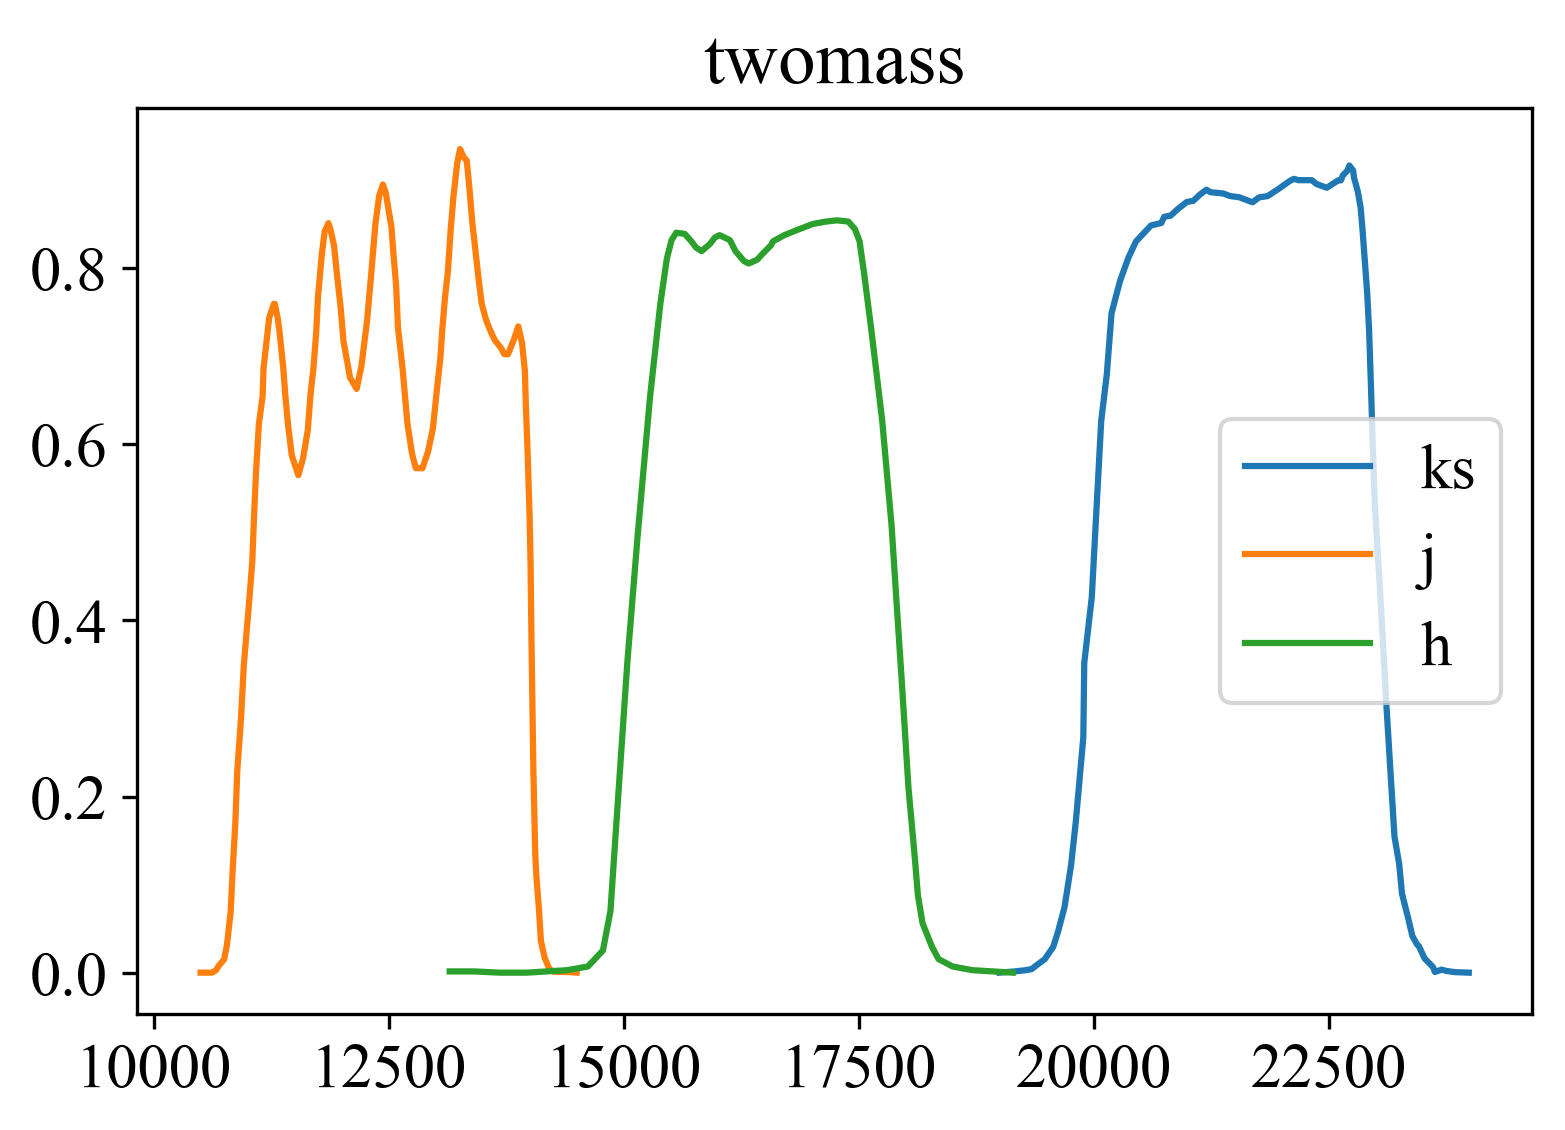

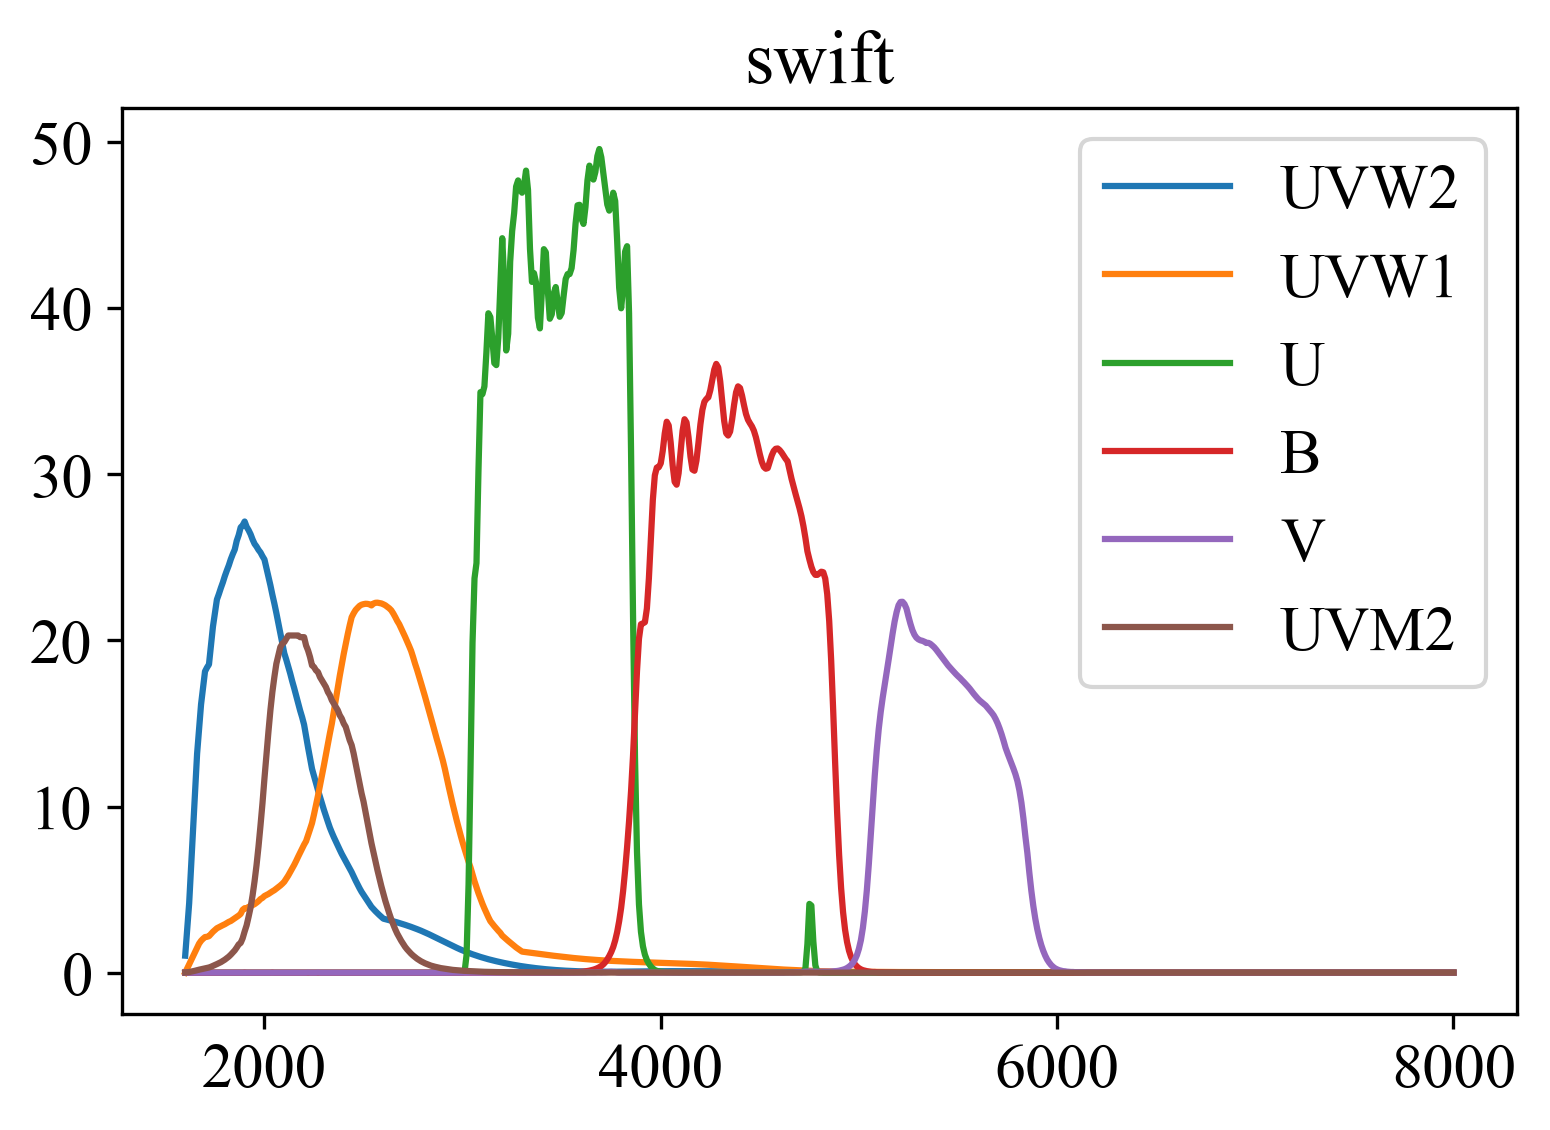

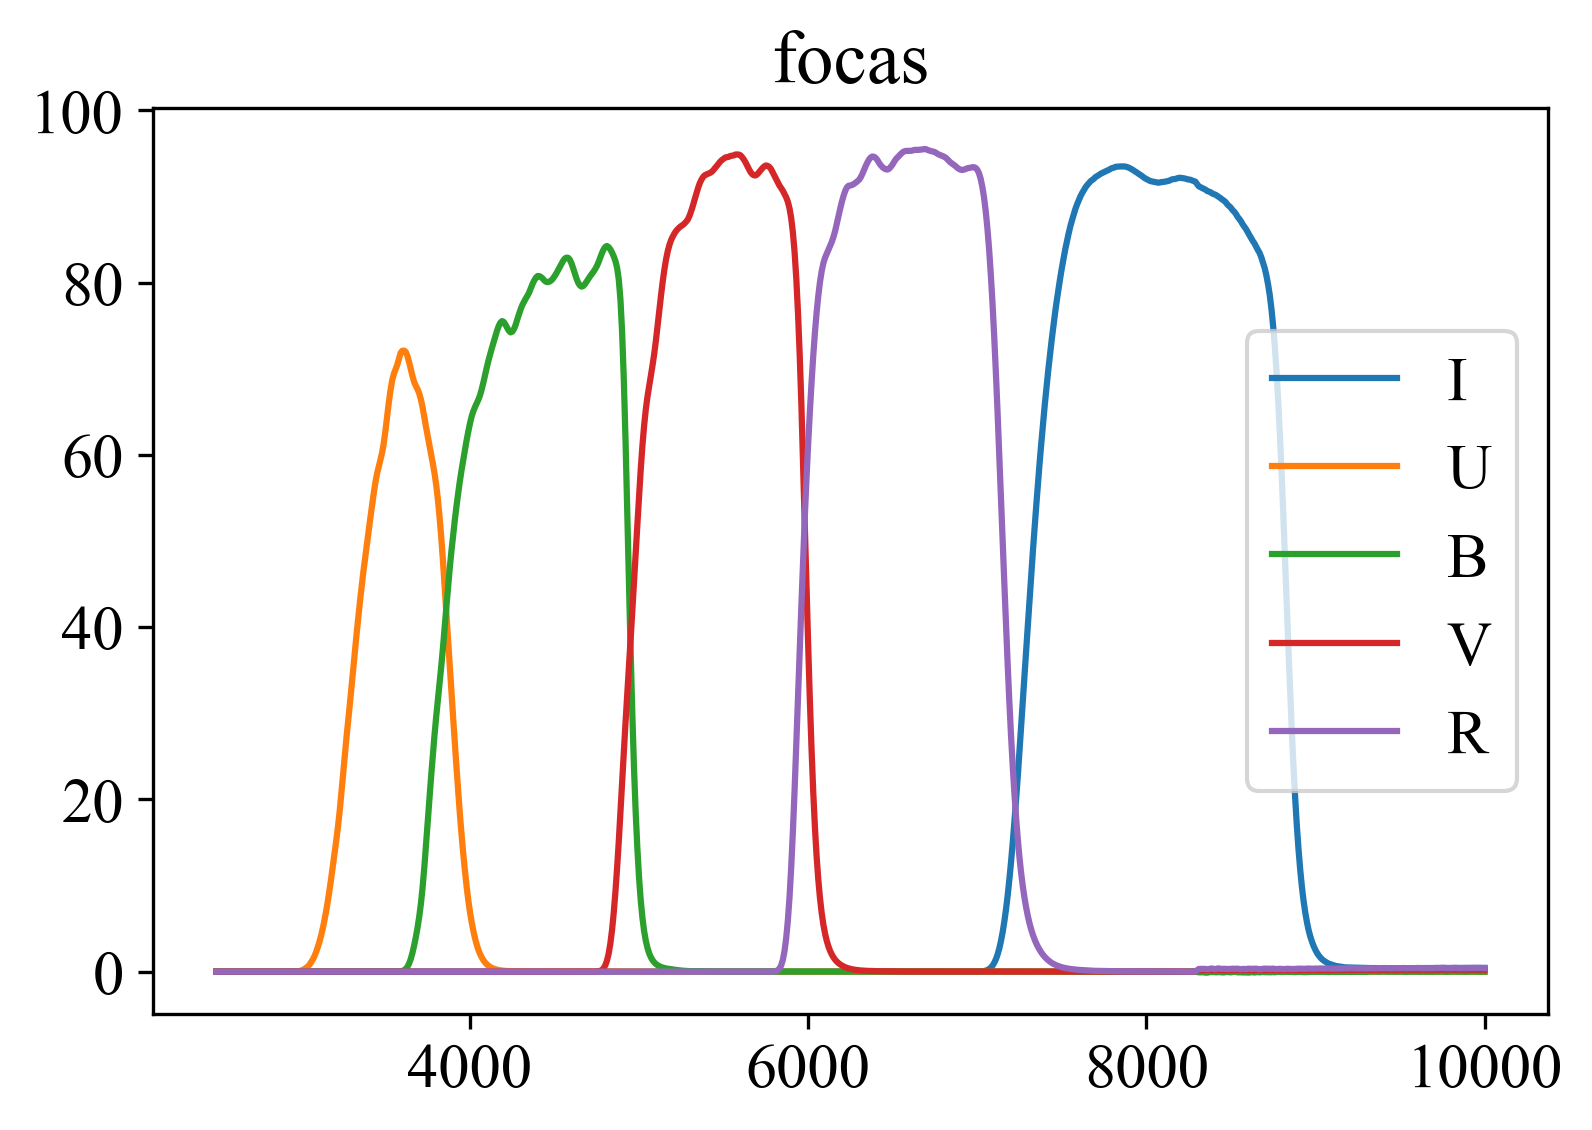

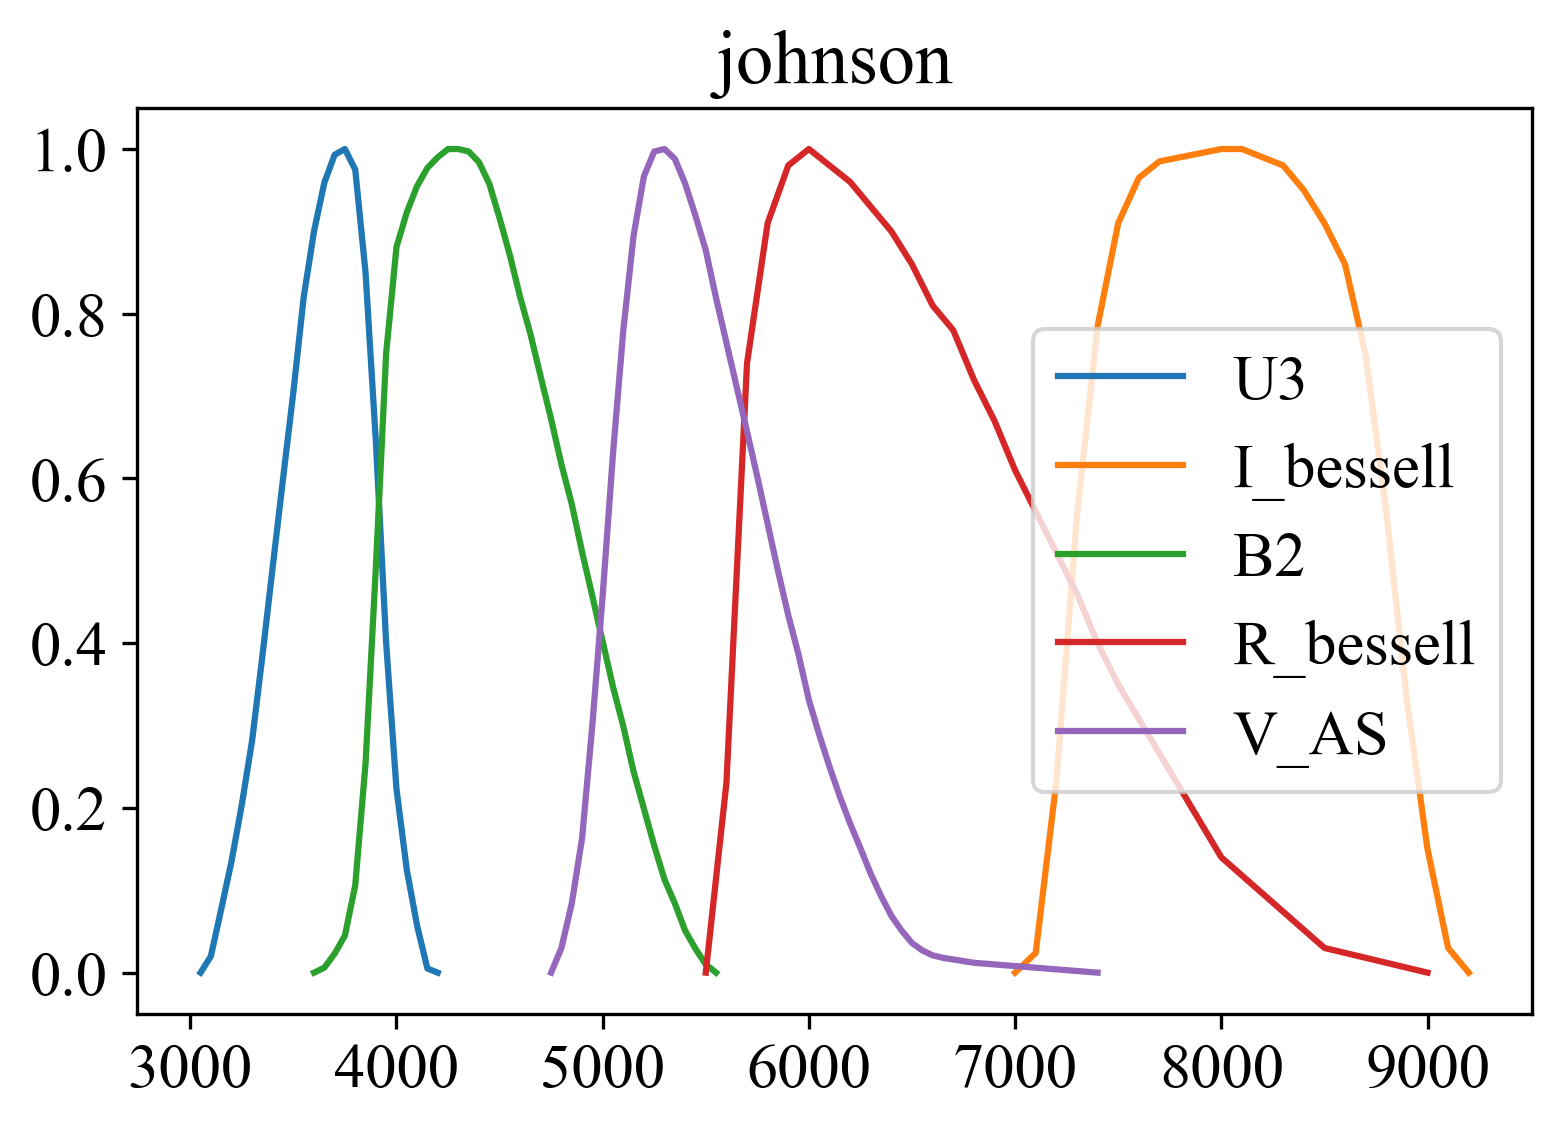

In [408]:
# directory_ = "filter_data/twomass"
plt.close()
supdir_ = "filter_data"
for directory_ in subprocess.getoutput('find {} -type d |grep /'.format(supdir_)).split("\n"):
    for filepath in subprocess.getoutput('find {} |grep txt'.format(directory_)).split("\n"):
#         print(filepath)
    #     filename = filepath.split("/")[-1]
#         new_filename = filepath.replace("_focas", "")
    # #     print(new_filename)
    #     subprocess.getoutput("mv {} {}".format(filepath, new_filename))
        filter_name = filepath.split("/")[-1].replace(".txt", "")
        a_ = np.loadtxt(filepath).swapaxes(0, 1)
        plt.plot(a_[0], a_[1], label = filter_name)
    plt.title(directory_.split("/")[-1])
    plt.legend()
    plt.show()
    plt.close()


In [590]:
%time spectra = read_Maeda_data(filepath_)
%time spectra = spectra.Doppler_shift_by_intrinsic_velocity(vel)

CPU times: user 5.97 s, sys: 11.7 s, total: 17.7 s
Wall time: 22.8 s
CPU times: user 31.4 s, sys: 9.81 s, total: 41.2 s
Wall time: 47.5 s


In [506]:
%time lc_ML, spectra_ML = read_MacLeod_data(Force=True)

lc_ML.data[:,:,:,1:] = 10**(-0.4 * lc_ML.data[:,:,:,1:])
lc_ML = lc_ML.binning(N_theta_bins=10, N_phi_bins=10)
lc_ML.data[:,:,:,1:] = -2.5*np.log10(lc_ML.data[:,:,:,1:])
lc_ML_bol = lc_ML.bolometric_luminosity_to_magnitude()
lc_ML.data[:,:,:,0] = lc_ML_bol.data


CPU times: user 3.15 s, sys: 926 ms, total: 4.08 s
Wall time: 2.72 s


In [409]:
%matplotlib inline
# %matplotlib notebook

In [410]:
print("MacLeod", spectra_ML.data.shape)
print("time\n",spectra_ML.times)
print("theta\n",spectra_ML.thetas)
print("phi\n",spectra_ML.phis)


MacLeod (16, 10, 10, 600)
time
 [ 4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 36. 40.]
theta
 [0.25892134 0.69716304 0.96834183 1.19537426 1.40334944 1.60413735
 1.80630233 2.01898641 2.25665138 2.55590903]
phi
 [0.1047 0.733  1.3614 1.9897 2.618  3.2463 3.8746 4.5029 5.1313 5.7596]


In [411]:
print("Maeda", spectra_reduced.data.shape)
print("time",spectra_reduced.times.size, "\n",spectra_reduced.times)
print("theta", spectra_reduced.thetas.size, "\n",spectra_reduced.thetas)
print("phi", spectra_reduced.phis.size, "\n",spectra_reduced.phis)


Maeda (71, 10, 10, 600)
time 71 
 [ 3.23593657  3.38844156  3.54813388  3.71535228  3.89045143  4.07380275
  4.26579516  4.46683589  4.67735137  4.89778815  5.12861378  5.3703179
  5.62341318  5.88843647  6.16594993  6.45654219  6.76082964  7.07945772
  7.41310227  7.76247101  8.12830499  8.51138019  8.91250917  9.33254278
  9.77237196 10.23292965 10.71519276 11.22018423 11.7489752  12.30268733
 12.88249511 13.48962839 14.12537497 14.79108337 15.48816564 16.21810038
 16.98243589 17.78279341 18.62087063 19.4984452  20.4173786  21.37961998
 22.38721041 23.4422871  24.54708803 25.70395662 26.91534675 28.18382793
 29.51209079 30.90295275 32.35936401 33.88441382 35.48133701 37.15352086
 38.90451232 40.73802545 42.6579494  44.66835657 46.77351131 48.97787894
 51.28613521 53.70317624 56.2341289  58.88436169 61.65949609 64.56541855
 67.60829291 70.79457352 74.1310189  77.62470611 81.28304572]
theta 10 
 [0.64350113 0.92729524 1.1592795  1.36943843 1.57079635 1.77215428
 1.98231321 2.21429748 2

In [433]:
system = "Vega"
# system = "AB"
# system = "ST"

lc_maeda_bol     = spectra_reduced.calc_bolometric_luminosity().bolometric_luminosity_to_magnitude()
lc_maeda_swift   = calc_band_flux(spectra_reduced, filters[2]).convert_flux_to_magnitude(filters[2], system=system)
lc_maeda_focas   = calc_band_flux(spectra_reduced, filters[0]).convert_flux_to_magnitude(filters[1], system=system)
lc_maeda_john    = calc_band_flux(spectra_reduced, filters[1]).convert_flux_to_magnitude(filters[1], system=system)
lc_maeda_twomass = calc_band_flux(spectra_reduced, filters[3]).convert_flux_to_magnitude(filters[3], system=system)


/Users/kawana/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:233: RuntimeWarning: divide by zero encountered in log10
/Users/kawana/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:270: RuntimeWarning: divide by zero encountered in log10


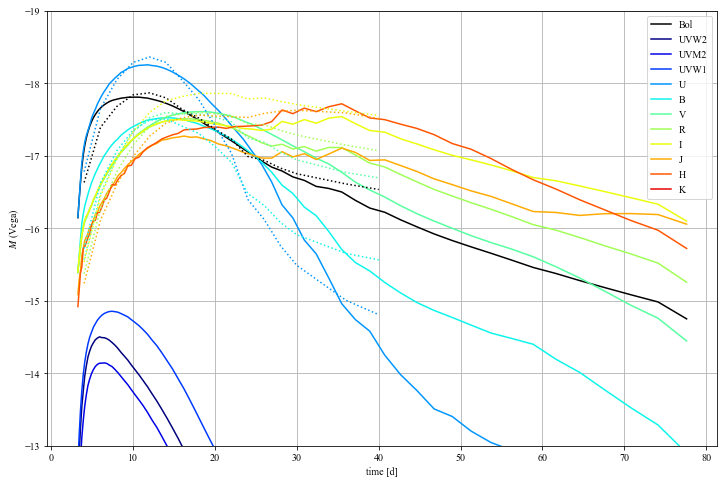

In [508]:

plt.figure(figsize=(12,8))

plt.plot(lc_maeda_bol.times, lc_maeda_bol.data[:,:,:].mean(axis=(1,2)), label="Bol", color="black")
# swift
list_index_bands = np.argsort(filters[2].effective_wavelength)
for i in list_index_bands[:3]:
    band = lc_maeda_swift.bands[i]
    plt.plot(lc_maeda_swift.times, lc_maeda_swift.data[:,:,:,i].mean(axis=(1,2)), 
             label=band,
             color=dict_color[band])

# #focas
# list_index_bands = np.argsort(filters[1].effective_wavelength)
# for i in list_index_bands:
#     band = lc_maeda_focas.bands[i][0].capitalize()
#     plt.plot(lc_maeda_focas.times, lc_maeda_focas.data[:,:,:,i].mean(axis=(1,2)), 
#              label=band,
#              color=dict_color[band])

#johnson
list_index_bands = np.argsort(filters[1].effective_wavelength)
for i in list_index_bands:
    band = lc_maeda_john.bands[i][0]
    plt.plot(lc_maeda_john.times, lc_maeda_john.data[:,:,:,i].mean(axis=(1,2)), 
             label=band,
             color=dict_color[band])

#twomass
list_index_bands = np.argsort(filters[3].effective_wavelength)
for i in list_index_bands:
    band = lc_maeda_twomass.bands[i][0].capitalize()
    plt.plot(lc_maeda_twomass.times, lc_maeda_twomass.data[:,:,:,i].mean(axis=(1,2)), 
             label=band,
             color=dict_color[band])

# plt.title("Maeda")
# plt.grid()
# plt.gca().invert_yaxis()
plt.legend()


plt.plot(lc_ML_bol.times, lc_ML_bol.data[:,:,:].mean(axis=(1,2)), label="Bol", color="black", linestyle=lss[3])
for i, band in enumerate(lc_ML.bands):
    if (i>0):
        plt.plot(lc_ML.times, lc_ML.data[:,:,:,i].mean(axis=(1,2)), 
    #                  label=band[1], 
                 color=dict_color[band[1]],
                 linestyle=lss[3])
    
# plt.title("MacLeod")
plt.xlabel("time [d]")
plt.ylabel(r"$M$ (Vega)")
plt.ylim(-19,-13)
plt.grid()
plt.gca().invert_yaxis()
# plt.legend()
# plt.savefig("figs/cowd/lc_compare.png")


In [ ]:
system = "Vega"
# system = "AB"
# system = "ST"

lc_maeda_bol     = spectra_reduced.calc_bolometric_luminosity().bolometric_luminosity_to_magnitude()
lc_maeda_swift   = calc_band_flux(spectra_reduced, filters[2]).convert_flux_to_magnitude(filters[2], system=system)
lc_maeda_focas   = calc_band_flux(spectra_reduced, filters[0]).convert_flux_to_magnitude(filters[1], system=system)
lc_maeda_john    = calc_band_flux(spectra_reduced, filters[1]).convert_flux_to_magnitude(filters[1], system=system)
lc_maeda_twomass = calc_band_flux(spectra_reduced, filters[3]).convert_flux_to_magnitude(filters[3], system=system)


In [ ]:

plt.figure(figsize=(12,8))

plt.plot(lc_maeda_bol.times, lc_maeda_bol.data[:,:,:].mean(axis=(1,2)), label="Bol", color="black")
# swift
list_index_bands = np.argsort(filters[2].effective_wavelength)
for i in list_index_bands[:3]:
    band = lc_maeda_swift.bands[i]
    plt.plot(lc_maeda_swift.times, lc_maeda_swift.data[:,:,:,i].mean(axis=(1,2)), 
             label=band,
             color=dict_color[band])

# #focas
# list_index_bands = np.argsort(filters[1].effective_wavelength)
# for i in list_index_bands:
#     band = lc_maeda_focas.bands[i][0].capitalize()
#     plt.plot(lc_maeda_focas.times, lc_maeda_focas.data[:,:,:,i].mean(axis=(1,2)), 
#              label=band,
#              color=dict_color[band])

#johnson
list_index_bands = np.argsort(filters[1].effective_wavelength)
for i in list_index_bands:
    band = lc_maeda_john.bands[i][0]
    plt.plot(lc_maeda_john.times, lc_maeda_john.data[:,:,:,i].mean(axis=(1,2)), 
             label=band,
             color=dict_color[band])

#twomass
list_index_bands = np.argsort(filters[3].effective_wavelength)
for i in list_index_bands:
    band = lc_maeda_twomass.bands[i][0].capitalize()
    plt.plot(lc_maeda_twomass.times, lc_maeda_twomass.data[:,:,:,i].mean(axis=(1,2)), 
             label=band,
             color=dict_color[band])

# plt.title("Maeda")
# plt.grid()
# plt.gca().invert_yaxis()
plt.legend()


plt.plot(lc_ML_bol.times, lc_ML_bol.data[:,:,:].mean(axis=(1,2)), label="Bol", color="black", linestyle=lss[3])
for i, band in enumerate(lc_ML.bands):
    if (i>0):
        plt.plot(lc_ML.times, lc_ML.data[:,:,:,i].mean(axis=(1,2)), 
    #                  label=band[1], 
                 color=dict_color[band[1]],
                 linestyle=lss[3])
    
# plt.title("MacLeod")
plt.xlabel("time [d]")
plt.ylabel(r"$M$ (Vega)")
plt.ylim(-19,-13)
plt.grid()
plt.gca().invert_yaxis()
# plt.legend()
# plt.savefig("figs/cowd/lc_compare.png")


In [581]:
# spectra_shifted = spectra.binning(N_theta_bins=10, N_phi_bins=20)
%time spectra_shifted = spectra.Doppler_shift_by_intrinsic_velocity(vel)

CPU times: user 26.6 s, sys: 10.7 s, total: 37.3 s
Wall time: 40 s


In [570]:
%matplotlib notebook

In [572]:
spectra_shifted.Doppler_shift_intrinsic[j_theta, k_phi]

0.9600541962602158

In [573]:
spectra.thetas[j_theta], spectra.phis[k_phi]

(1.6208172094167248, 1.5707963267948966)

In [502]:
lc_ML.data

array([[[[-16.35654777, -16.62374949, -15.57684516, ..., -15.244104  ,
          -15.40833048, -15.13107393],
         [-16.14427267, -16.4545942 , -15.42737631, ..., -15.12896039,
          -15.28488453, -15.03202591],
         [-16.41781584, -16.68360758, -15.64950277, ..., -15.35364792,
          -15.48650548, -15.19975757],
         ...,
         [-16.79988666, -17.05746649, -15.97461051, ..., -15.58010287,
          -15.74130311, -15.44114117],
         [-16.81037104, -17.03931038, -15.972441  , ..., -15.57074077,
          -15.73769827, -15.38801257],
         [-16.69706192, -16.89934988, -15.83918868, ..., -15.46733726,
          -15.62023819, -15.31752756]],

        [[-16.22243155, -16.39932133, -15.34926307, ..., -15.06547546,
          -15.20439695, -14.88128949],
         [-15.62099851, -15.91830962, -14.92075309, ..., -14.8106408 ,
          -14.99498084, -14.8096679 ],
         [-16.29509327, -16.48586963, -15.45709772, ..., -15.24098327,
          -15.40644698, -15.10421

In [ ]:
i_time_maeda=2
i_time_ML=0
j_theta= 5
k_phi=0

# plt.title("")
plt.plot(spectra_reduced.wavelengths, spectra_reduced.data[i_time,j_theta,k_phi], label="t={} d".format(spectra_reduced.times[i_time_maeda]))
plt.plot(spectra_ML.wavelengths, spectra_ML.data[i_time,j_theta,k_phi], label="t={} d".format(spectra_ML.times[i_time_ML]))
plt.legend()

# preparation

In [ ]:
def set_parameters(
    distance = 10. *u.Mpc, 
):
    return {
        "distance": distance
    }

params = set_parameters()

# spectra

In [ ]:
theta_bins, phi_bins, spectra = get_spectra(head_table, data_table, 
                                            N_theta_bins=1,
                                            N_phi_bins=1)

In [ ]:
# plt.figure(figsize=(14,10))
for i in range(time_arr.size):
    if (i % 10 == 0):
        plt.plot(wava, unit_conversion(wava, spectra[i, 0, 0].sum()), label="{:.0f} d".format(time_arr[i]))
plt.legend()

In [ ]:
bol_lumi = np.sum(spectra[:, 0, 0, 1:] * np.diff(wava), axis=-1)
abmag = -2.5 * np.log10(bol_lumi * u.erg/ u.s / u.Bol)
abmag2 = -2.5 * np.log10(1e-12 * bol_lumi * u.erg/ u.s / u.Bol)

In [ ]:
fig, ax1 = plt.subplots()

ax1.semilogy(time_arr[:-2], bol_lumi[:-2], linestyle=lss[0])
ax1.semilogy(times_lc_ML, data_lc_ML.mean(axis=(1,2))[:,0], linestyle=lss[1])
plt.ylim(1e41, 1e43)
ax2 = ax1.twinx()
ax2.set_ylim(-2.5 * np.log10(1e41 * u.erg/ u.s / u.Bol), -2.5 * np.log10(1e43 * u.erg/ u.s / u.Bol))
# ax2 = ax1.set_ylim()
# ax2.set_ylim()
# plt.gca().invert_yaxis()
# plt.ylim(-13,-19)
# plt.legend()
ax1.grid()


# light curve

In [ ]:
cosmo = astropy.cosmology.Planck15

In [ ]:
cosmo

In [1]:
import photontools

In [4]:
fitlers[2].instrument

'swift'

In [ ]:
def get_bol_lightcurve(
    header_table,
    wavelengths,
    data_table,
    N_theta_bins: int = 1,
    N_phi_bins : int = 1,
    Filter = "Johnson",
    distance = 10 * u.Mpc,
    E_B_V = 0.,
    redshift = 0.,
    
):
    """
    calculate isotropic lightcurve with given theta_bins and phi_bins
    * Todo: implement Filter, E_B_V, redshift
    
    arguments
    =========
    header_table:
    data_table  : photon bins
    N_theta_bins:
    N_phi_bins  :

    requirement
    ===========
    mod(N_theta/phi_input, N_theta/phi_bins) = 0 
    * KK will implement generalized binning using interpolation 
    
    return
    ======
    theta_bins: float, np.ndarray: [theta_0, ...,theta_N_theta_bins], size=N_theta_bins+1
    phi_bins  : float, np.ndarray: [phi_0, ...,phi_N_phi_bins], size=N_phi_bins+1
    lightcurve: float, np.ndarray: [N_band x N_time x N_theta x N_phi]in units of erg/s 
                                   where N_band = (number of bands in given Filter) + 1 (bolometric)
    """

    if (Filter != "Johnson" or Filter != "Swift"):
        raise ValueError ('Argument "Filter" must be "Johnson" or "Swift" now')
    
    times, thetas, phis = extract_array_from_header(header_table)
    
    if (thetas.size % N_theta_bins != 0):
        raise ValueError ("mod(N_theta_input, N_theta_bins) must be 0")

    if (phis.size % N_phi_bins != 0):
        raise ValueError ("mod(N_phi_input, N_phi_bins) must be 0")
        
    
    theta_every = int(theta_arr.size / N_theta_bins)
    phi_every   = int(phi_arr.size / N_phi_bins)

    theta_bins = np.append([0], thetas[theta_every-1::theta_every])
    phi_bins   = np.append([0], phis[phi_every-1::phi_every])
    
    data_reshaped = data_table.reshape(time_arr.size, 
                                       N_theta_bins, 
                                       theta_every, 
                                       N_phi_bins, 
                                       phi_every, 
                                       data_table.shape[-1]
                                      )
    
    # caluculate isotropic luminosity
    lc = data_reshaped.mean(axis=(2, 4))
    # here, shape of lc: [N_time, N_theta, N_phi, N_wavelength]
    lc = lc.swapaxes(1, 2).swapaxes(1,3) 
    # here, shape of lc: [N_time, N_wavelength, N_theta, N_phi]
    solid_angles = - np.tile(np.diff(phi_bins), (theta_bins.size-1, 1)) * np.diff(np.cos(theta_bins))
    lc = lc / solid_angles
    lc = lc.swapaxes(1, 2).swapaxes(1,3) 
    # here, shape of lc: [N_time, N_wavelength, N_theta, N_phi]

    luminosity = flux[:,:,1:] * np.diff(wavelengths)
    lc = lc / ()
    return theta_bins, phi_bins, spectra


In [ ]:
theta_arr1 = np.append(0, theta_arr)
phi_arr1 = np.append(0, phi_arr)
theta_arr1